In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd, qr, norm, inv, pinv

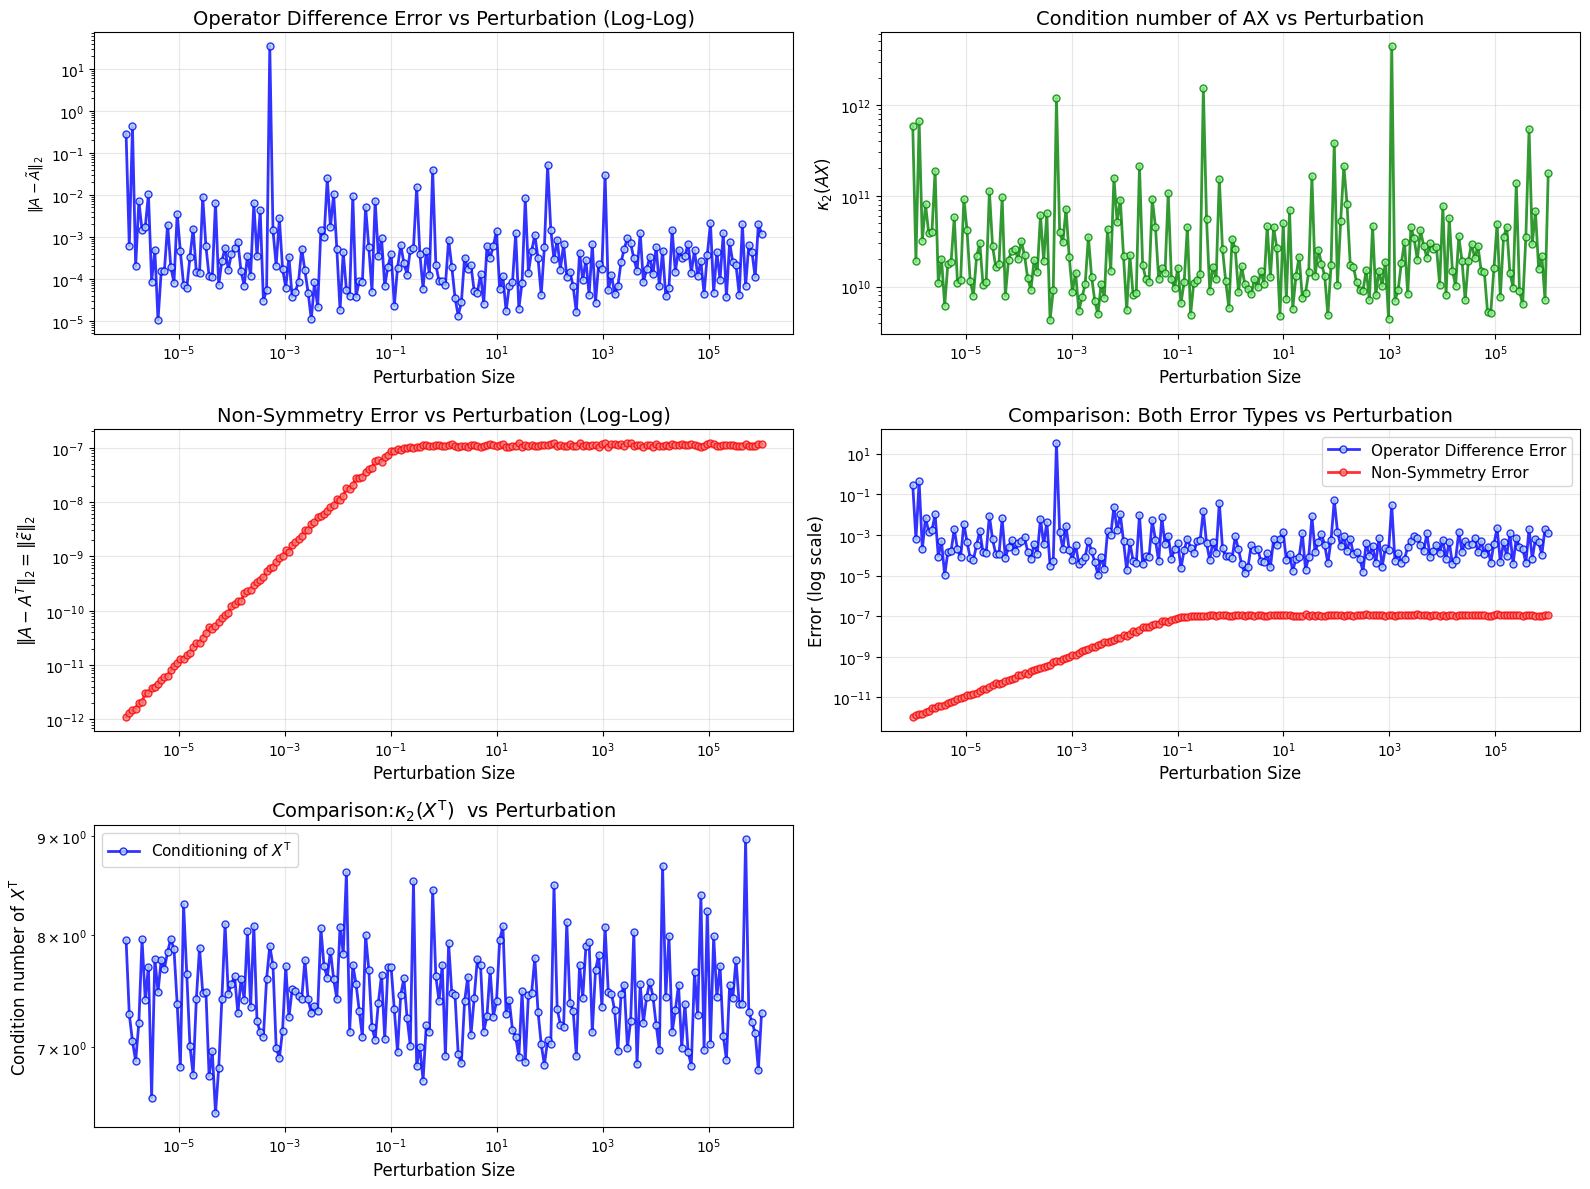


Detailed Statistics:
Perturbation range: 1.00e-06 to 1.00e+06

Operator Difference Error:
  Range: 1.03e-05 to 3.50e+01
  Mean: 1.80e-01
  Std: 2.47e+00

Non-Symmetry Error:
  Range: 1.11e-12 to 1.24e-07
  Mean: 6.79e-08
  Std: 5.17e-08

Correlations (in log space):
  Perturbation vs Operator Error: -0.1519
  Perturbation vs Symmetry Error: 0.8468

Estimated Power Law Relationships:
  Operator Error ∝ (perturbation)^-0.04
  Symmetry Error ∝ (perturbation)^0.38
Conditioning for $AX$:  Maximum: 4.449057e+12, Mimumum: 4.256370e+09
Conditioning for $X^\text{T}$:  Maximum: 8.970402e+00, Mimumum: 6.465326e+00


In [30]:
n = 100
r = 10

exp_values = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2] # Made some small some medium size and some large singular values
exp_values_reversed = exp_values[::-1]

Q, _ = qr(np.random.randn(n, r))
A_sym = Q @ np.diag(exp_values_reversed) @ Q.T


small_sv_indices = [-3, -2, -1]  # or range(-3, 0) or [7, 8, 9] for r=10
perturbation_size = np.logspace(-6,6,200)

new_error = []
gradual_symmetric_error = []
conditioning_AX = []
conditioning_XT = []

for i, pert_size in enumerate(perturbation_size):

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    for j in small_sv_indices:
        Q_pert_new[:, j] += pert_size * np.random.randn(n)

    # Re-orthogonalize to maintain orthogonality, remains an SVD
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    epsilon = A - A.T

    X = np.random.rand(n, r)

    cond_XT = np.linalg.cond(X.T)
    
    conditioning_XT.append(cond_XT)

    AX = A @ X

    cond_AX = np.linalg.cond(AX)
    
    conditioning_AX.append(cond_AX)

    A_nyst = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    #if (np.linalg.norm((AX) @ np.linalg.inv(X.T @ AX) @ (X.T @ epsilon @ X) @ np.linalg.pinv(X)) - np.linalg.norm(A - A_nyst) < 1e-12).all :

    operator_difference = A - A_nyst# (AX) @ np.linalg.inv(X.T @ AX) @ (X.T @ epsilon @ X)

    #else:
        #ValueError

    error_A_A_nyst = np.linalg.norm(operator_difference,2)

    new_error.append(error_A_A_nyst)

    symmetry_err = np.linalg.norm(A - A.T,2)

    gradual_symmetric_error.append(symmetry_err)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
ax1, ax2, ax3, ax4, ax5 = axes.flatten()[:5]
axes.flatten()[-1].set_visible(False)   # hide sixth

# Plot 1: Log-log plot of operator difference error
ax1.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8)
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel(r'$\|A - \tilde{A}\|_2$')
ax1.set_title('Operator Difference Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)


ax2.loglog(perturbation_size, conditioning_AX, 'g-o', linewidth=2, markersize=5,
             markerfacecolor='lightgreen', markeredgecolor='green', alpha=0.8)
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel(r'$\kappa_2(AX)$', fontsize=12)
ax2.set_title('Condition number of AX vs Perturbation', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-log plot of symmetry error
ax3.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8)
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel(r'$\|A - A^T\|_2 = \|\tilde{\epsilon}\|_2$', fontsize=12)
ax3.set_title('Non-Symmetry Error vs Perturbation (Log-Log)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label='Operator Difference Error')
ax4.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8,
           label='Non-Symmetry Error')
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Both Error Types vs Perturbation', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)

ax5.loglog(perturbation_size, conditioning_XT, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label=r'Conditioning of $X^\text{T}$')
ax5.set_xlabel('Perturbation Size', fontsize=12)
ax5.set_ylabel(r'Condition number of $X^\text{T}$', fontsize=12)
ax5.set_title(r'Comparison:$\kappa_2(X^\text{T})$  vs Perturbation', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=11)

plt.tight_layout()
plt.show()


# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Perturbation range: {min(perturbation_size):.2e} to {max(perturbation_size):.2e}")
print(f"\nOperator Difference Error:")
print(f"  Range: {min(new_error):.2e} to {max(new_error):.2e}")
print(f"  Mean: {np.mean(new_error):.2e}")
print(f"  Std: {np.std(new_error):.2e}")
print(f"\nNon-Symmetry Error:")
print(f"  Range: {min(gradual_symmetric_error):.2e} to {max(gradual_symmetric_error):.2e}")
print(f"  Mean: {np.mean(gradual_symmetric_error):.2e}")
print(f"  Std: {np.std(gradual_symmetric_error):.2e}")

# Calculate correlations in log space
log_pert = np.log10(perturbation_size)
log_op_error = np.log10(new_error)
log_sym_error = np.log10(gradual_symmetric_error)

corr_op = np.corrcoef(log_pert, log_op_error)[0,1]
corr_sym = np.corrcoef(log_pert, log_sym_error)[0,1]

print(f"\nCorrelations (in log space):")
print(f"  Perturbation vs Operator Error: {corr_op:.4f}")
print(f"  Perturbation vs Symmetry Error: {corr_sym:.4f}")

# Estimate slopes (power law relationships)
poly_op = np.polyfit(log_pert, log_op_error, 1)
poly_sym = np.polyfit(log_pert, log_sym_error, 1)

print(f"\nEstimated Power Law Relationships:")
print(f"  Operator Error ∝ (perturbation)^{poly_op[0]:.2f}")
print(f"  Symmetry Error ∝ (perturbation)^{poly_sym[0]:.2f}")


print(r"Conditioning for $AX$: ", f"Maximum: {np.max(conditioning_AX):.6e}, Mimumum: {np.min(conditioning_AX):.6e}")
print(r"Conditioning for $X^\text{T}$: ", f"Maximum: {np.max(conditioning_XT):.6e}, Mimumum: {np.min(conditioning_XT):.6e}")

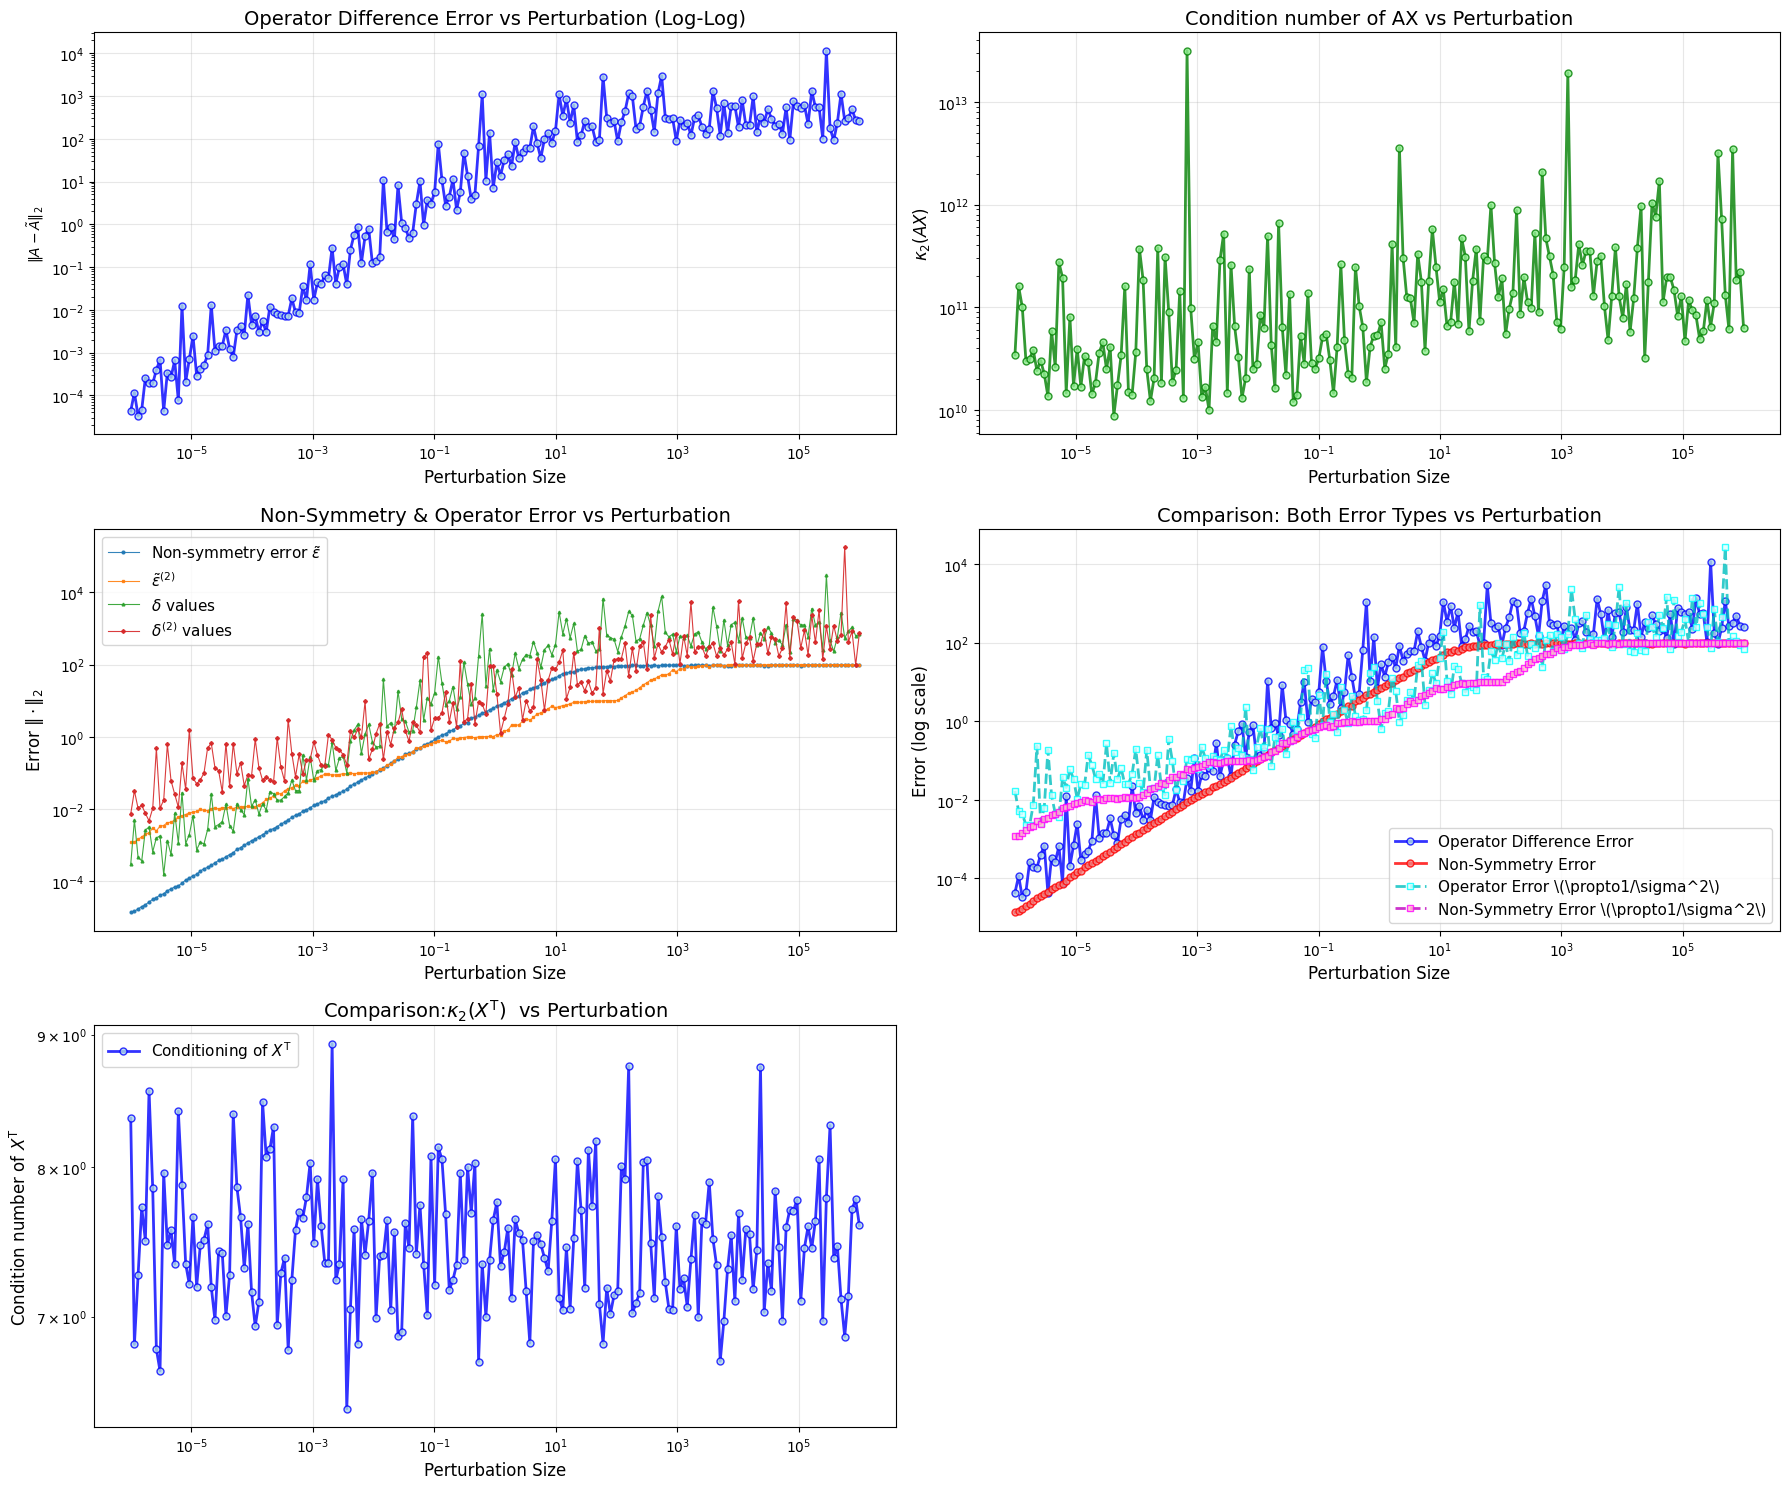


Detailed Statistics:
Perturbation range: 1.00e-06 to 1.00e+06

Operator Difference Error:
  Range: 3.33e-05 to 2.20e-05
  Mean: 2.62e+02
  Std: 8.92e+02

Non-Symmetry Error:
  Range: 1.37e-05 to 9.91e+01
  Mean: 4.02e+01
  Std: 4.46e+01

Correlations (in log space):
  Perturbation vs Operator Error: 0.9235
  Perturbation vs Symmetry Error: 0.9421

Estimated Power Law Relationships:
  Operator Error ∝ (perturbation)^0.60
  Symmetry Error ∝ (perturbation)^0.61
Conditioning for $AX$:  Maximum: 3.158360e+13, Mimumum: 8.777800e+09
Conditioning for $X^\text{T}$:  Maximum: 8.927392e+00, Mimumum: 6.446912e+00


In [56]:
new_error_2 = []
gradual_symmetric_error_2 = []
conditioning_AX_2 = []
conditioning_XT_2 = []
delta_vals = []

diag_vals = 1.0 / np.array(exp_values_reversed)

# now make diagonal matrix
diagonal_matrix = np.diag(diag_vals)

# --- before your loop, define the 1/σ² diagonal matrix ---
diag_vals_sq   = 1.0/np.array(exp_values_reversed)**2
diagonal_matrix_sq = np.diag(diag_vals_sq)

# allocate storage for the new scheme
new_error_sq = []
sym_error_sq = []
delta_sq_vals = []


for i, pert_size in enumerate(perturbation_size):

    G = np.random.rand(n,r)

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    
    Q_pert_new = Q + pert_size * (G @ diagonal_matrix)

    # Re-orthogonalize to maintain orthogonality, remains an SVD
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    epsilon = A - A.T

    X = np.random.rand(n, r)

    cond_XT_2 = np.linalg.cond(X.T)
    
    conditioning_XT_2.append(cond_XT_2)

    AX = A @ X

    cond_AX_2 = np.linalg.cond(AX)
    
    conditioning_AX_2.append(cond_AX_2)

    A_nyst_2 = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    delta = A_nyst_2 - A_nyst_2.T

    delta_vals.append(np.linalg.norm(delta,2))

    operator_difference_2 = (AX) @ np.linalg.inv(X.T @ AX) @ (X.T @ epsilon @ X) @ np.linalg.pinv(X)

    error_A_A_nyst_2 = np.linalg.norm(operator_difference_2, 2)

    new_error_2.append(error_A_A_nyst_2)

    symmetry_err_2 = np.linalg.norm(A - A.T,2)

    gradual_symmetric_error_2.append(symmetry_err_2)

for pert_size in perturbation_size:
    G = np.random.randn(n, r)

    # perturb with 1/sigma^2 weighting
    Q_pert_sq, _ = np.linalg.qr( Q + pert_size * (G @ diagonal_matrix_sq) )

    A_sq = Q @ np.diag(exp_values_reversed) @ Q_pert_sq.T
    A_sq_nyst = (A_sq @ X) @ np.linalg.inv(X.T @ A_sq @ X) @ (A_sq @ X).T
    eps_sq = A_sq - A_sq.T
    delta_sq = A_sq_nyst - A_sq_nyst.T

    # same operators as before
    X = np.random.rand(n, r)
    AX = A_sq @ X
    op_diff_sq = AX @ np.linalg.inv(X.T @ AX) @ (X.T @ eps_sq @ X) @ np.linalg.pinv(X)
    new_error_sq.append( np.linalg.norm(op_diff_sq,2) )
    sym_error_sq.append( np.linalg.norm(eps_sq,2) )
    delta_sq_vals.append(np.linalg.norm(delta_sq,2))



fig, axes = plt.subplots(3, 2, figsize=(18, 15))
ax1, ax2, ax3, ax4, ax5 = axes.flatten()[:5]
axes.flatten()[-1].set_visible(False)   # hide sixth

# Plot 1: Log-log plot of operator difference error
ax1.loglog(perturbation_size, new_error_2, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8)
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel(r'$\|A - \tilde{A}\|_2$')
ax1.set_title('Operator Difference Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)


ax2.loglog(perturbation_size, conditioning_AX_2, 'g-o', linewidth=2, markersize=5,
             markerfacecolor='lightgreen', markeredgecolor='green', alpha=0.8)
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel(r'$\kappa_2(AX)$', fontsize=12)
ax2.set_title('Condition number of AX vs Perturbation', fontsize=14)
ax2.grid(True, alpha=0.3)

styles = [
    dict(color='tab:blue',   marker='o', linestyle='-',  label=r'Non-symmetry error $\tilde{\epsilon}$'),
    dict(color='tab:orange', marker='s', linestyle='-',  label=r'$\tilde{\epsilon}^{(2)}$'),
    dict(color='tab:green',  marker='^', linestyle='-',  label=r'$\delta$ values'),
    dict(color='tab:red',    marker='D', linestyle='-',  label=r'$\delta^{(2)}$ values')
]

ax3.loglog(perturbation_size, gradual_symmetric_error_2, **styles[0],
           linewidth=0.8, markersize=2, alpha=0.90)
ax3.loglog(perturbation_size, sym_error_sq,             **styles[1],
           linewidth=0.8, markersize=2, alpha=0.90)
ax3.loglog(perturbation_size, delta_vals,               **styles[2],
           linewidth=0.8, markersize=2, alpha=0.90)
ax3.loglog(perturbation_size, delta_sq_vals,            **styles[3],
           linewidth=0.8, markersize=2, alpha=0.90)
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel(r'Error $\|\cdot\|_2$', fontsize=12)
ax3.set_title('Non-Symmetry & Operator Error vs Perturbation', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(perturbation_size, new_error_2, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label='Operator Difference Error')
ax4.loglog(perturbation_size, gradual_symmetric_error_2, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8,
           label='Non-Symmetry Error')
ax4.loglog(perturbation_size, new_error_sq,  'c--s', linewidth=2, markersize=5,
           markerfacecolor='lightcyan', markeredgecolor='cyan', alpha=0.8,
           label=r'Operator Error \(\propto1/\sigma^2\)')
ax4.loglog(perturbation_size, sym_error_sq,  'm--s', linewidth=2, markersize=5,
           markerfacecolor='pink', markeredgecolor='magenta', alpha=0.8,
           label=r'Non‐Symmetry Error \(\propto1/\sigma^2\)')
ax4.legend(fontsize=10)
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Both Error Types vs Perturbation', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)

ax5.loglog(perturbation_size, conditioning_XT_2, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label=r'Conditioning of $X^\text{T}$')
ax5.set_xlabel('Perturbation Size', fontsize=12)
ax5.set_ylabel(r'Condition number of $X^\text{T}$', fontsize=12)
ax5.set_title(r'Comparison:$\kappa_2(X^\text{T})$  vs Perturbation', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=11)

plt.tight_layout()
plt.show()


# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Perturbation range: {min(perturbation_size):.2e} to {max(perturbation_size):.2e}")
print(f"\nOperator Difference Error:")
print(f"  Range: {min(new_error_2):.2e} to {max(new_error):.2e}")
print(f"  Mean: {np.mean(new_error_2):.2e}")
print(f"  Std: {np.std(new_error_2):.2e}")
print(f"\nNon-Symmetry Error:")
print(f"  Range: {min(gradual_symmetric_error_2):.2e} to {max(gradual_symmetric_error_2):.2e}")
print(f"  Mean: {np.mean(gradual_symmetric_error_2):.2e}")
print(f"  Std: {np.std(gradual_symmetric_error_2):.2e}")

# Calculate correlations in log space
log_pert = np.log10(perturbation_size)
log_op_error_2 = np.log10(new_error_2)
log_sym_error_2 = np.log10(gradual_symmetric_error_2)

corr_op_2 = np.corrcoef(log_pert, log_op_error_2)[0,1]
corr_sym_2 = np.corrcoef(log_pert, log_sym_error_2)[0,1]

print(f"\nCorrelations (in log space):")
print(f"  Perturbation vs Operator Error: {corr_op_2:.4f}")
print(f"  Perturbation vs Symmetry Error: {corr_sym_2:.4f}")

# Estimate slopes (power law relationships)
poly_op_2 = np.polyfit(log_pert, log_op_error_2, 1)
poly_sym_2 = np.polyfit(log_pert, log_sym_error_2, 1)

print(f"\nEstimated Power Law Relationships:")
print(f"  Operator Error ∝ (perturbation)^{poly_op_2[0]:.2f}")
print(f"  Symmetry Error ∝ (perturbation)^{poly_sym_2[0]:.2f}")


print(r"Conditioning for $AX$: ", f"Maximum: {np.max(conditioning_AX_2):.6e}, Mimumum: {np.min(conditioning_AX_2):.6e}")
print(r"Conditioning for $X^\text{T}$: ", f"Maximum: {np.max(conditioning_XT_2):.6e}, Mimumum: {np.min(conditioning_XT_2):.6e}")

In [ ]:
"""sample_size = 1000

A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

Omega_set = []

for i in range(sample_size):

    random_matrix = np.random.randn(n,r)

    A_X = A @ random_matrix

    A_tilde = (A_X) @ np.linalg.inv(X.T @ A_X) @ (A_X).T

    Omega_set.append(A_tilde)

max_diameter = 0
num_pairs = 0

for i in range(len(Omega_set)):
    for j in range(i+1, len(Omega_set)):
        diameter = np.linalg.norm(Omega_set[i] - Omega_set[j], 2)
        max_diameter = max(max_diameter, diameter)
        num_pairs += 1

print("2 - norm estimation: ", max_diameter)
print("number of pairs considered: ", num_pairs)"""



2 - norm estimation:  5383.350718157556
number of pairs considered:  499500


VERIFICATION OF NORM EQUALITY

Checking if ||operator_difference|| = ||A - A_nyst|| at each perturbation level:
--------------------------------------------------------------------------------
Perturbation   1 (size=1.00e-06):
  ||operator_difference||     = 1.113909539486e-12
  ||A - A_nyst||             = 3.691634998617e-04
  Absolute difference:         = 3.691634987478e-04
  Relative difference:         = 3.314124582488e+08

WARNING at perturbation 1: Norms differ by 3.69e-04
  This might indicate numerical issues or theoretical assumption violation

Perturbation   2 (size=1.15e-06):
  ||operator_difference||     = 1.258051620265e-12
  ||A - A_nyst||             = 2.076274938268e-03
  Absolute difference:         = 2.076274937010e-03
  Relative difference:         = 1.650389303240e+09

WARNING at perturbation 2: Norms differ by 2.08e-03
  This might indicate numerical issues or theoretical assumption violation

Perturbation   3 (size=1.32e-06):
  ||operator_difference||     = 1.475

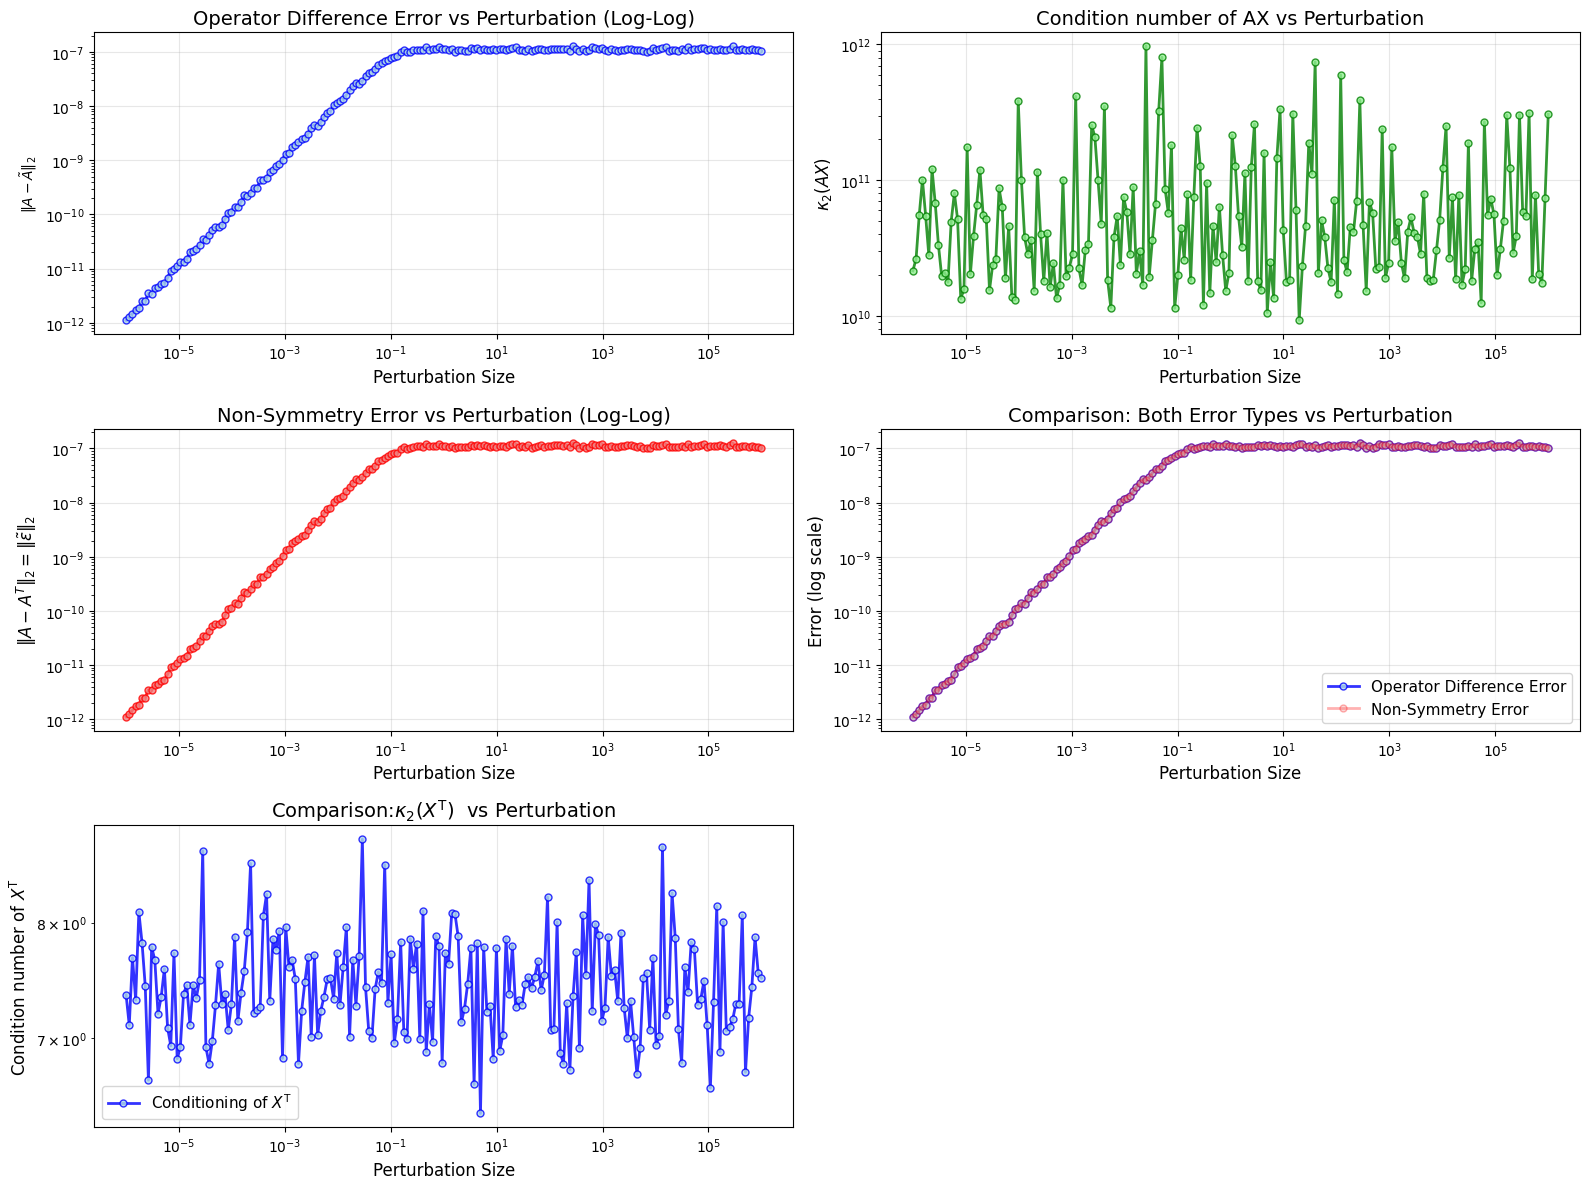


Detailed Statistics:
Perturbation range: 1.00e-06 to 1.00e+06

Operator Difference Error:
  Range: 1.11e-12 to 1.28e-07
  Mean: 6.75e-08
  Std: 5.14e-08

Non-Symmetry Error:
  Range: 1.11e-12 to 1.28e-07
  Mean: 6.75e-08
  Std: 5.14e-08

Correlations (in log space):
  Perturbation vs Operator Error: 0.8456
  Perturbation vs Symmetry Error: 0.8456

Estimated Power Law Relationships:
  Operator Error ∝ (perturbation)^0.38
  Symmetry Error ∝ (perturbation)^0.38
Conditioning for $AX$:  Maximum: 9.739804e+11, Mimumum: 9.316817e+09
Conditioning for $X^\text{T}$:  Maximum: 8.812102e+00, Mimumum: 6.411935e+00


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import qr

n = 100
r = 10

exp_values = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2] # Made some small some medium size and some large singular values
exp_values_reversed = exp_values[::-1]

Q, _ = qr(np.random.randn(n, r))
A_sym = Q @ np.diag(exp_values_reversed) @ Q.T


small_sv_indices = [-3, -2, -1]  # or range(-3, 0) or [7, 8, 9] for r=10
perturbation_size = np.logspace(-6,6,200)

new_error = []
gradual_symmetric_error = []
conditioning_AX = []
conditioning_XT = []

# Add verification tracking
verification_differences = []

print("="*80)
print("VERIFICATION OF NORM EQUALITY")
print("="*80)
print("\nChecking if ||operator_difference|| = ||A - A_nyst|| at each perturbation level:")
print("-"*80)

for i, pert_size in enumerate(perturbation_size):

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    for j in small_sv_indices:
        Q_pert_new[:, j] += pert_size * np.random.randn(n)

    # Re-orthogonalize to maintain orthogonality, remains an SVD
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    epsilon = A - A.T

    X = np.random.rand(n, r)

    cond_XT = np.linalg.cond(X.T)
    
    conditioning_XT.append(cond_XT)

    AX = A @ X

    cond_AX = np.linalg.cond(AX)
    
    conditioning_AX.append(cond_AX)

    A_nyst = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    # Calculate both norms
    operator_difference = epsilon #(AX) @ np.linalg.inv(X.T @ AX) @ (X.T@ epsilon @ X) @ np.linalg.pinv(X)
    norm_operator_diff = np.linalg.norm(operator_difference, 2)
    norm_A_minus_Anyst = np.linalg.norm(A - A_nyst, 2)
    
    # Calculate the difference between the two norms
    norm_difference = abs(norm_operator_diff - norm_A_minus_Anyst)
    verification_differences.append(norm_difference)
    
    # Print verification at key points (first few, middle, and last few)
    if i < 3 or i == len(perturbation_size)//2 or i >= len(perturbation_size)-3:
        print(f"Perturbation {i+1:3d} (size={pert_size:.2e}):")
        print(f"  ||operator_difference||     = {norm_operator_diff:.12e}")
        print(f"  ||A - A_nyst||             = {norm_A_minus_Anyst:.12e}")
        print(f"  Absolute difference:         = {norm_difference:.12e}")
        print(f"  Relative difference:         = {norm_difference/max(norm_operator_diff, 1e-16):.12e}")
        print()
    
    # Verify they are approximately equal
    if norm_difference > 1e-10 * max(norm_operator_diff, 1):
        print(f"WARNING at perturbation {i+1}: Norms differ by {norm_difference:.2e}")
        print(f"  This might indicate numerical issues or theoretical assumption violation")
        print()

    error_A_A_nyst = norm_operator_diff  # Use the operator difference as the error

    new_error.append(error_A_A_nyst)

    symmetry_err = np.linalg.norm(A - A.T,2)

    gradual_symmetric_error.append(symmetry_err)

# Print summary statistics for verification
print("="*80)
print("VERIFICATION SUMMARY")
print("="*80)
print(f"Maximum difference between norms: {max(verification_differences):.2e}")
print(f"Mean difference between norms:    {np.mean(verification_differences):.2e}")
print(f"Std of differences:              {np.std(verification_differences):.2e}")
print()

if max(verification_differences) < 1e-10:
    print("✓ VERIFICATION SUCCESSFUL: The two norms are equal within numerical precision!")
else:
    print("⚠ VERIFICATION WARNING: Some differences exceed numerical tolerance.")
    print(f"  Number of cases with difference > 1e-10: {sum(d > 1e-10 for d in verification_differences)}")
print("="*80)
print()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
ax1, ax2, ax3, ax4, ax5 = axes.flatten()[:5]
axes.flatten()[-1].set_visible(False)   # hide sixth

# Plot 1: Log-log plot of operator difference error
ax1.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8)
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel(r'$\|A - \tilde{A}\|_2$')
ax1.set_title('Operator Difference Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)


ax2.loglog(perturbation_size, conditioning_AX, 'g-o', linewidth=2, markersize=5,
             markerfacecolor='lightgreen', markeredgecolor='green', alpha=0.8)
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel(r'$\kappa_2(AX)$', fontsize=12)
ax2.set_title('Condition number of AX vs Perturbation', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-log plot of symmetry error
ax3.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8)
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel(r'$\|A - A^T\|_2 = \|\tilde{\epsilon}\|_2$', fontsize=12)
ax3.set_title('Non-Symmetry Error vs Perturbation (Log-Log)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label='Operator Difference Error')
ax4.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.3,
           label='Non-Symmetry Error')
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Both Error Types vs Perturbation', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)

ax5.loglog(perturbation_size, conditioning_XT, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label=r'Conditioning of $X^\text{T}$')
ax5.set_xlabel('Perturbation Size', fontsize=12)
ax5.set_ylabel(r'Condition number of $X^\text{T}$', fontsize=12)
ax5.set_title(r'Comparison:$\kappa_2(X^\text{T})$  vs Perturbation', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=11)

plt.tight_layout()
plt.show()


# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Perturbation range: {min(perturbation_size):.2e} to {max(perturbation_size):.2e}")
print(f"\nOperator Difference Error:")
print(f"  Range: {min(new_error):.2e} to {max(new_error):.2e}")
print(f"  Mean: {np.mean(new_error):.2e}")
print(f"  Std: {np.std(new_error):.2e}")
print(f"\nNon-Symmetry Error:")
print(f"  Range: {min(gradual_symmetric_error):.2e} to {max(gradual_symmetric_error):.2e}")
print(f"  Mean: {np.mean(gradual_symmetric_error):.2e}")
print(f"  Std: {np.std(gradual_symmetric_error):.2e}")

# Calculate correlations in log space
log_pert = np.log10(perturbation_size)
log_op_error = np.log10(new_error)
log_sym_error = np.log10(gradual_symmetric_error)

corr_op = np.corrcoef(log_pert, log_op_error)[0,1]
corr_sym = np.corrcoef(log_pert, log_sym_error)[0,1]

print(f"\nCorrelations (in log space):")
print(f"  Perturbation vs Operator Error: {corr_op:.4f}")
print(f"  Perturbation vs Symmetry Error: {corr_sym:.4f}")

# Estimate slopes (power law relationships)
poly_op = np.polyfit(log_pert, log_op_error, 1)
poly_sym = np.polyfit(log_pert, log_sym_error, 1)

print(f"\nEstimated Power Law Relationships:")
print(f"  Operator Error ∝ (perturbation)^{poly_op[0]:.2f}")
print(f"  Symmetry Error ∝ (perturbation)^{poly_sym[0]:.2f}")


print(r"Conditioning for $AX$: ", f"Maximum: {np.max(conditioning_AX):.6e}, Mimumum: {np.min(conditioning_AX):.6e}")
print(r"Conditioning for $X^\text{T}$: ", f"Maximum: {np.max(conditioning_XT):.6e}, Mimumum: {np.min(conditioning_XT):.6e}")

VERIFICATION OF NORM EQUALITY

Checking if ||operator_difference|| = ||A - A_nyst|| at each perturbation level:
--------------------------------------------------------------------------------
Perturbation   1 (size=1.00e-06):
  ||epsilon|| (asymmetry)     = 6.471047069629e-12
  ||A - A_nyst|| (error)      = 9.670267068324e-04
  Ratio (error/asymmetry):     = 149438985.1329

Perturbation   2 (size=1.15e-06):
  ||epsilon|| (asymmetry)     = 2.863914557684e-12
  ||A - A_nyst|| (error)      = 1.628241105705e-05
  Ratio (error/asymmetry):     = 5685369.0042

Perturbation   3 (size=1.32e-06):
  ||epsilon|| (asymmetry)     = 1.469092646672e-11
  ||A - A_nyst|| (error)      = 1.050266435681e-03
  Ratio (error/asymmetry):     = 71490823.8129

Perturbation 101 (size=1.07e+00):
  ||epsilon|| (asymmetry)     = 1.124151265701e-07
  ||A - A_nyst|| (error)      = 5.647928084353e-05
  Ratio (error/asymmetry):     = 502.4171

Perturbation 198 (size=7.58e+05):
  ||epsilon|| (asymmetry)     = 7.82433679

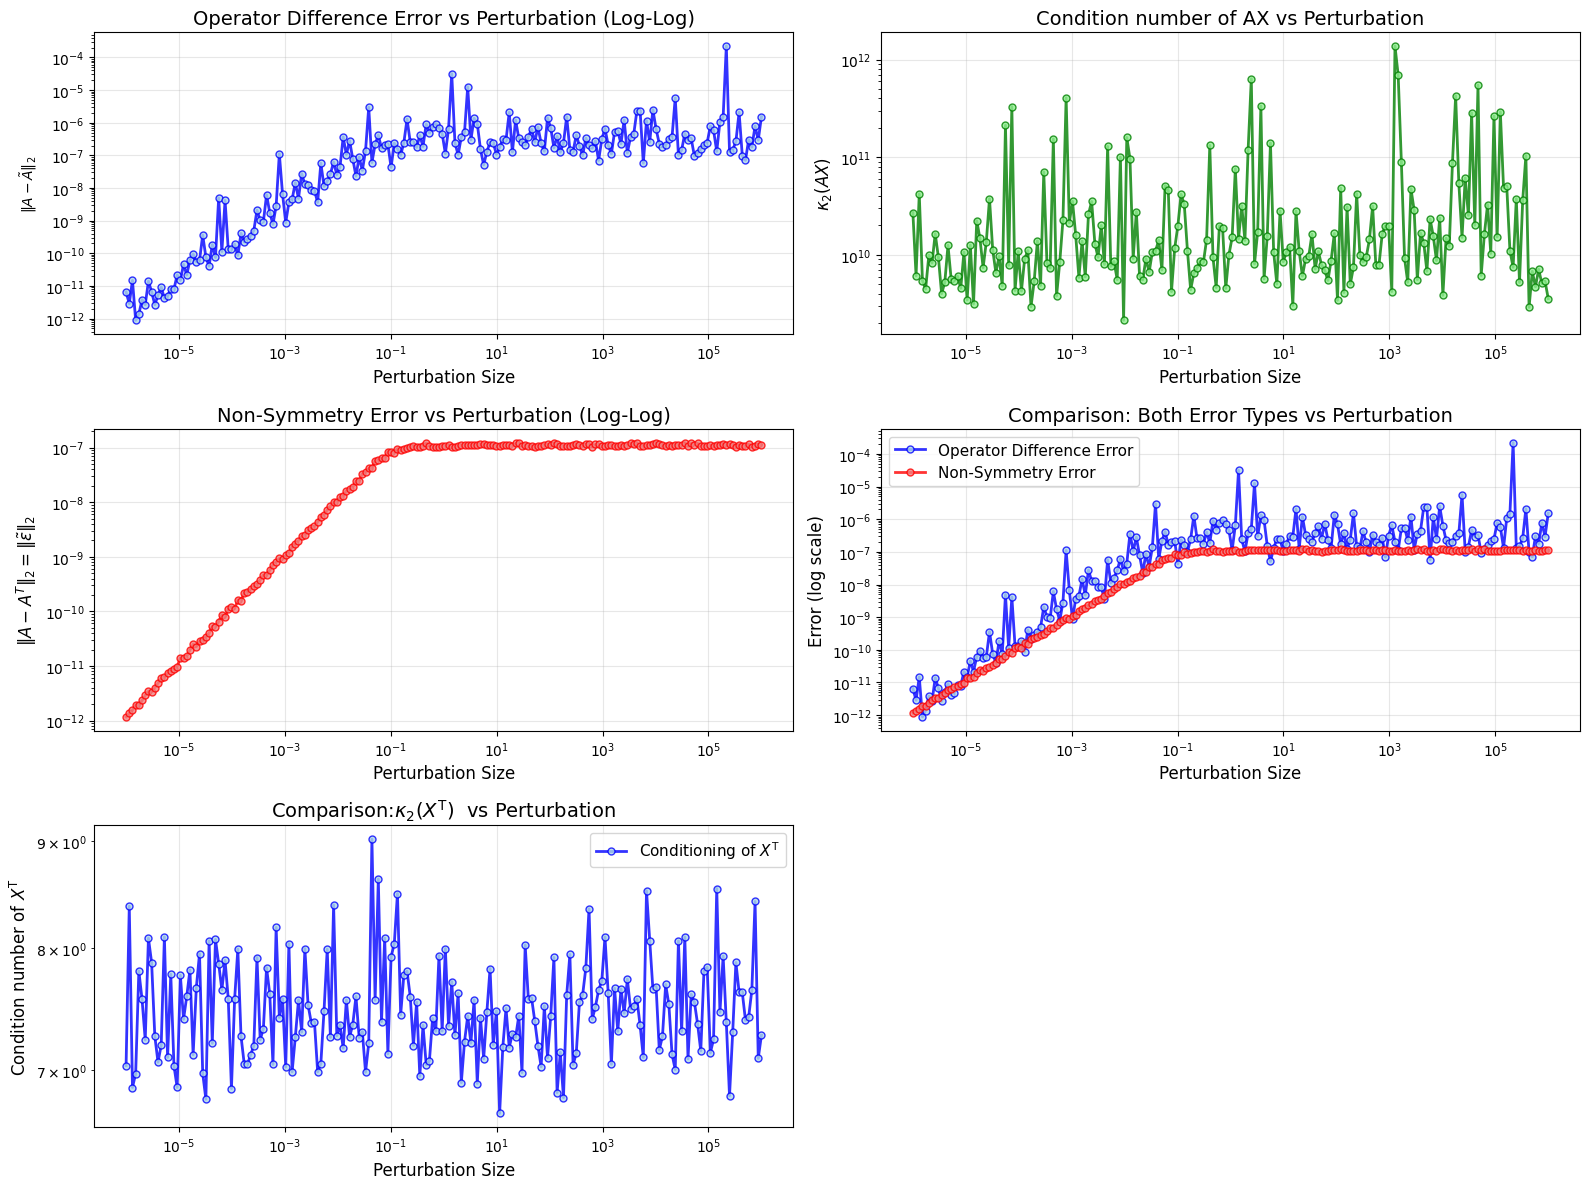


Detailed Statistics:
Perturbation range: 1.00e-06 to 1.00e+06

Operator Difference Error:
  Range: 8.84e-13 to 2.23e-04
  Mean: 1.67e-06
  Std: 1.59e-05

Non-Symmetry Error:
  Range: 1.17e-12 to 1.24e-07
  Mean: 6.78e-08
  Std: 5.16e-08

Correlations (in log space):
  Perturbation vs Operator Error: 0.8014
  Perturbation vs Symmetry Error: 0.8476

Estimated Power Law Relationships:
  Operator Error ∝ (perturbation)^0.39
  Symmetry Error ∝ (perturbation)^0.38
Conditioning for $AX$:  Maximum: 1.374743e+12, Mimumum: 2.138858e+09
Conditioning for $X^\text{T}$:  Maximum: 9.019705e+00, Mimumum: 6.675031e+00


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import qr

n = 100
r = 10

exp_values = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2] # Made some small some medium size and some large singular values
exp_values_reversed = exp_values[::-1]

Q, _ = qr(np.random.randn(n, r))
A_sym = Q @ np.diag(exp_values_reversed) @ Q.T


small_sv_indices = [-3, -2, -1]  # or range(-3, 0) or [7, 8, 9] for r=10
perturbation_size = np.logspace(-6,6,200)

new_error = []
gradual_symmetric_error = []
conditioning_AX = []
conditioning_XT = []

# Add verification tracking
verification_differences = []

print("="*80)
print("VERIFICATION OF NORM EQUALITY")
print("="*80)
print("\nChecking if ||operator_difference|| = ||A - A_nyst|| at each perturbation level:")
print("-"*80)

for i, pert_size in enumerate(perturbation_size):

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    for j in small_sv_indices:
        Q_pert_new[:, j] += pert_size * np.random.randn(n)

    # Re-orthogonalize to maintain orthogonality, remains an SVD
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    epsilon = A - A.T

    X = np.random.rand(n, r)

    cond_XT = np.linalg.cond(X.T)
    
    conditioning_XT.append(cond_XT)

    AX = A @ X

    cond_AX = np.linalg.cond(AX)
    
    conditioning_AX.append(cond_AX)

    A_nyst = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    # Calculate both norms
    operator_difference = (AX) @ np.linalg.inv(X.T @ AX) @ (X.T @ epsilon @ X) @ np.linalg.pinv(X)
    norm_operator_diff = np.linalg.norm(operator_difference, 2)
    norm_A_minus_Anyst = np.linalg.norm(A - A_nyst, 2)
    
    # Calculate the ratio between the two norms (for correlation analysis)
    if norm_operator_diff > 1e-15:
        norm_ratio = norm_A_minus_Anyst / norm_operator_diff
    else:
        norm_ratio = np.inf
    verification_differences.append(norm_ratio)
    
    # Print comparison at key points (first few, middle, and last few)
    if i < 3 or i == len(perturbation_size)//2 or i >= len(perturbation_size)-3:
        print(f"Perturbation {i+1:3d} (size={pert_size:.2e}):")
        print(f"  ||epsilon|| (asymmetry)     = {norm_operator_diff:.12e}")
        print(f"  ||A - A_nyst|| (error)      = {norm_A_minus_Anyst:.12e}")
        print(f"  Ratio (error/asymmetry):     = {norm_ratio:.4f}")
        print()

    error_A_A_nyst = norm_operator_diff  # Use the operator difference as the error

    new_error.append(error_A_A_nyst)

    symmetry_err = np.linalg.norm(A - A.T,2)

    gradual_symmetric_error.append(symmetry_err)

# Print summary statistics for correlation analysis
print("="*80)
print("CORRELATION ANALYSIS SUMMARY")
print("="*80)
# Filter out infinities for statistics
finite_ratios = [r for r in verification_differences if np.isfinite(r)]
if finite_ratios:
    print(f"Ratio of ||A - A_nyst|| to ||epsilon||:")
    print(f"  Mean ratio:     {np.mean(finite_ratios):.4f}")
    print(f"  Std of ratios:  {np.std(finite_ratios):.4f}")
    print(f"  Min ratio:      {np.min(finite_ratios):.4f}")
    print(f"  Max ratio:      {np.max(finite_ratios):.4f}")
    
    # Calculate correlation between the two norms
    correlation = np.corrcoef(gradual_symmetric_error, new_error)[0,1]
    print(f"\nCorrelation between ||epsilon|| and ||A - A_nyst||: {correlation:.6f}")
    
    if correlation > 0.9:
        print("✓ STRONG CORRELATION: The asymmetry and Nyström error are highly correlated!")
    elif correlation > 0.7:
        print("✓ GOOD CORRELATION: The asymmetry and Nyström error are well correlated.")
    else:
        print("⚠ WEAK CORRELATION: The relationship is more complex than expected.")
else:
    print("Unable to compute ratios (epsilon too small)")
print("="*80)
print()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
ax1, ax2, ax3, ax4, ax5 = axes.flatten()[:5]
axes.flatten()[-1].set_visible(False)   # hide sixth

# Plot 1: Log-log plot of operator difference error
ax1.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8)
ax1.set_xlabel('Perturbation Size', fontsize=12)
ax1.set_ylabel(r'$\|A - \tilde{A}\|_2$')
ax1.set_title('Operator Difference Error vs Perturbation (Log-Log)', fontsize=14)
ax1.grid(True, alpha=0.3)


ax2.loglog(perturbation_size, conditioning_AX, 'g-o', linewidth=2, markersize=5,
             markerfacecolor='lightgreen', markeredgecolor='green', alpha=0.8)
ax2.set_xlabel('Perturbation Size', fontsize=12)
ax2.set_ylabel(r'$\kappa_2(AX)$', fontsize=12)
ax2.set_title('Condition number of AX vs Perturbation', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: Log-log plot of symmetry error
ax3.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8)
ax3.set_xlabel('Perturbation Size', fontsize=12)
ax3.set_ylabel(r'$\|A - A^T\|_2 = \|\tilde{\epsilon}\|_2$', fontsize=12)
ax3.set_title('Non-Symmetry Error vs Perturbation (Log-Log)', fontsize=14)
ax3.grid(True, alpha=0.3)

# Plot 4: Both errors on the same plot for comparison
ax4.loglog(perturbation_size, new_error, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label='Operator Difference Error')
ax4.loglog(perturbation_size, gradual_symmetric_error, 'r-o', linewidth=2, markersize=5,
           markerfacecolor='lightcoral', markeredgecolor='red', alpha=0.8,
           label='Non-Symmetry Error')
ax4.set_xlabel('Perturbation Size', fontsize=12)
ax4.set_ylabel('Error (log scale)', fontsize=12)
ax4.set_title('Comparison: Both Error Types vs Perturbation', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)

ax5.loglog(perturbation_size, conditioning_XT, 'b-o', linewidth=2, markersize=5,
           markerfacecolor='lightblue', markeredgecolor='blue', alpha=0.8, 
           label=r'Conditioning of $X^\text{T}$')
ax5.set_xlabel('Perturbation Size', fontsize=12)
ax5.set_ylabel(r'Condition number of $X^\text{T}$', fontsize=12)
ax5.set_title(r'Comparison:$\kappa_2(X^\text{T})$  vs Perturbation', fontsize=14)
ax5.grid(True, alpha=0.3)
ax5.legend(fontsize=11)

plt.tight_layout()
plt.show()


# Print detailed statistics
print(f"\nDetailed Statistics:")
print(f"Perturbation range: {min(perturbation_size):.2e} to {max(perturbation_size):.2e}")
print(f"\nOperator Difference Error:")
print(f"  Range: {min(new_error):.2e} to {max(new_error):.2e}")
print(f"  Mean: {np.mean(new_error):.2e}")
print(f"  Std: {np.std(new_error):.2e}")
print(f"\nNon-Symmetry Error:")
print(f"  Range: {min(gradual_symmetric_error):.2e} to {max(gradual_symmetric_error):.2e}")
print(f"  Mean: {np.mean(gradual_symmetric_error):.2e}")
print(f"  Std: {np.std(gradual_symmetric_error):.2e}")

# Calculate correlations in log space
log_pert = np.log10(perturbation_size)
log_op_error = np.log10(new_error)
log_sym_error = np.log10(gradual_symmetric_error)

corr_op = np.corrcoef(log_pert, log_op_error)[0,1]
corr_sym = np.corrcoef(log_pert, log_sym_error)[0,1]

print(f"\nCorrelations (in log space):")
print(f"  Perturbation vs Operator Error: {corr_op:.4f}")
print(f"  Perturbation vs Symmetry Error: {corr_sym:.4f}")

# Estimate slopes (power law relationships)
poly_op = np.polyfit(log_pert, log_op_error, 1)
poly_sym = np.polyfit(log_pert, log_sym_error, 1)

print(f"\nEstimated Power Law Relationships:")
print(f"  Operator Error ∝ (perturbation)^{poly_op[0]:.2f}")
print(f"  Symmetry Error ∝ (perturbation)^{poly_sym[0]:.2f}")


print(r"Conditioning for $AX$: ", f"Maximum: {np.max(conditioning_AX):.6e}, Mimumum: {np.min(conditioning_AX):.6e}")
print(r"Conditioning for $X^\text{T}$: ", f"Maximum: {np.max(conditioning_XT):.6e}, Mimumum: {np.min(conditioning_XT):.6e}")

In [27]:




for i, pert_size in enumerate(perturbation_size):

    # Create targeted perturbation
    Q_pert_new = Q.copy()
    for j in small_sv_indices:
        Q_pert_new[:, j] += pert_size * np.random.randn(n)

    # Re-orthogonalize to maintain orthogonality, remains an SVD
    Q_pert_new, _ = np.linalg.qr(Q_pert_new)

    A = Q @ np.diag(exp_values_reversed) @ Q_pert_new.T

    epsilon = A - A.T

    X = np.random.rand(n, r)

    cond_XT = np.linalg.cond(X.T)
    
    conditioning_XT.append(cond_XT)

    AX = A @ X

    cond_AX = np.linalg.cond(AX)
    
    conditioning_AX.append(cond_AX)

    A_nyst = (AX) @ np.linalg.pinv(X.T @ AX) @ (AX).T

    expression_1 = abs((AX) @ np.linalg.inv(X.T @ AX) @ (X.T @ epsilon @ X))

    expression_2 = abs(AX - A_nyst@X)

    print(expression_1, expression_2)


[[9.83580839e-13 1.50936186e-12 1.16952831e-12 1.63459031e-12
  2.40970860e-12 2.45191022e-12 1.46131530e-12 1.90318816e-12
  1.95492285e-12 2.28387588e-12]
 [2.06299281e-12 2.65022264e-12 2.17535469e-12 3.40672797e-12
  5.16395823e-12 5.28249851e-12 3.30151005e-12 4.14188007e-12
  4.15448871e-12 4.60147725e-12]
 [1.62861395e-12 2.12728255e-12 1.78119436e-12 2.74457340e-12
  4.16593073e-12 4.28841401e-12 2.69643582e-12 3.27110222e-12
  3.37020717e-12 3.69820022e-12]
 [2.73223421e-12 3.60282309e-12 2.83783666e-12 4.47058110e-12
  7.02800876e-12 7.01112933e-12 4.30093976e-12 5.55459461e-12
  5.58776229e-12 6.09207130e-12]
 [4.46542715e-12 6.03830875e-12 4.86402123e-12 7.45026537e-12
  1.13114523e-11 1.15016059e-11 7.06166585e-12 8.96785196e-12
  9.13601978e-12 1.00877759e-11]
 [2.21706955e-12 3.22093391e-12 2.43788534e-12 3.79545530e-12
  5.97104823e-12 5.93200606e-12 3.53765729e-12 4.61118472e-12
  4.83758931e-12 5.32035325e-12]
 [3.29360465e-12 4.70286051e-12 3.69780231e-12 5.57447085e